# Convolutional Neural Network - Triangular


### Import Packages


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis

# Check If GPU Enabled
Latest functioning version set as of October 6, 2024 according to https://www.tensorflow.org/install/source_windows is
- Python 3.10.11
- Tensorflow 2.10
- CUDA Toolkit 11.2
- CUDNN 8.1

In [2]:
# tf.debugging.set_log_device_placement(True) # For Verbose Output
print("Version: ", tf.__version__)


print("Num GPUs Available: ", tf.config.list_physical_devices("GPU"))


gpus = tf.config.list_physical_devices("GPU")
if gpus:

    print("TensorFlow is using GPU")
    for gpu in gpus:

        print(gpu.name)
else:

    print("TensorFlow is not using GPU")

Version:  2.17.0
Num GPUs Available:  []
TensorFlow is not using GPU


# Pick Datasets to Train


In [3]:
lunar_train_dir = r"../../data/lunar/training/data/S12_GradeA"
num_of_events = len(
    [file for file in os.listdir(lunar_train_dir) if file.endswith(".csv")]
)
print("Number of events: ", num_of_events)
event = [i for i in range(5)]  # num_of_events

Number of events:  76


# Import Catalog


In [4]:
catalog_path = r"../../data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
catalog = pd.read_csv(catalog_path)
catalog

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


# Get Filename and Anomaly Position

In [5]:
event_filename = [catalog["filename"][i] + r".csv" for i in event]
print("Event Filenames:", event_filename)

true_anomaly_time = [int(catalog["time_rel(sec)"][i]) for i in event]
print("Anomaly Positions in Each File:", true_anomaly_time)

Event Filenames: ['xa.s12.00.mhz.1970-01-19HR00_evid00002.csv', 'xa.s12.00.mhz.1970-03-25HR00_evid00003.csv', 'xa.s12.00.mhz.1970-03-26HR00_evid00004.csv', 'xa.s12.00.mhz.1970-04-25HR00_evid00006.csv', 'xa.s12.00.mhz.1970-04-26HR00_evid00007.csv']
Anomaly Positions in Each File: [73500, 12720, 73020, 4440, 52140]


## Load Lunar Training Data


In [6]:
csv_files_path = r"../../data/lunar/training/data/S12_GradeA"
csv_files = [os.path.join(csv_files_path, file) for file in event_filename]
print(csv_files)

['../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-01-19HR00_evid00002.csv', '../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-03-25HR00_evid00003.csv', '../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-03-26HR00_evid00004.csv', '../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-04-25HR00_evid00006.csv', '../../data/lunar/training/data/S12_GradeA\\xa.s12.00.mhz.1970-04-26HR00_evid00007.csv']


# Get Length, Time, and Speed of Each Event
Load all .csv's into one dataframe. Additionally, take the standard normal value of the velocity values, *i.e.*
$$
    X_{standard} = \frac{X - \mu_X}{\sigma_X}.
$$

In [7]:
lens_array = []
time_arrays = []
data_arrays = []
for file in csv_files:
    df = pd.read_csv(file)

    lens_array.append(len(df))

    t = df["time_rel(sec)"].values
    time_arrays.append(t)

    X = df["velocity(m/s)"].values
    X_standard = (X - np.mean(X)) / np.std(X)
    data_arrays.append(X_standard)


time_array = np.concatenate(time_arrays)
time = pd.DataFrame(time_array, columns=["time_rel(sec)"])

data_array = np.concatenate(data_arrays)
seismic_data = pd.DataFrame(data_array, columns=["velocity(m/s)"])

## Data Preparation


In [8]:
X_standard = seismic_data["velocity(m/s)"].values
X_standard = X_standard.astype(np.float32)  # To save memory

# Create Window Sequences

In [9]:
windows_size = 16
batch_size = 500

# Create sequences for CNN
windows = []
for i in range(len(X_standard) - windows_size):
    windows.append(X_standard[i : i + windows_size])

windows = np.array(windows)

In [10]:
print(windows.shape)

(2862047, 16)


# Get True Anomaly Labels

Creates a triangular labelling, peaked at the true anomaly.

True Anomaly Position: 73500


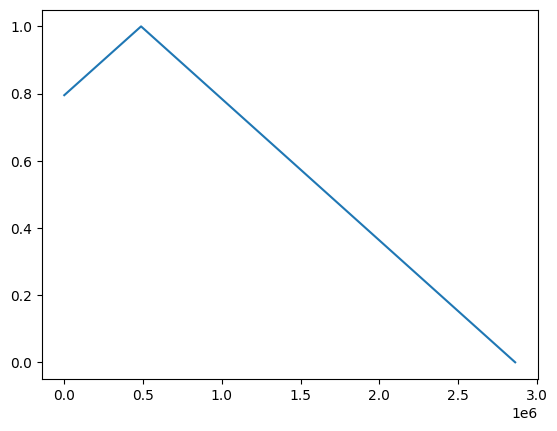

In [12]:
width = 20
freq = 6.625
sampling_freq = 1 / freq


def proximity_list(length, true_anomaly_index):
    proximity = np.zeros(length)  # Initialize list with zeros
    max_distance = max(
        true_anomaly_index, length - 1 - true_anomaly_index
    )  # Max distance from certain_index to the start/end
    for i in range(length):
        # Calculate distance from the certain index
        distance = abs(i - true_anomaly_index)
        # Normalize the value so it peaks at 1 at the certain index and decreases symmetrically
        proximity[i] = 1 - (distance / max_distance)
    return proximity


y = proximity_list(len(X_standard[windows_size:]), freq * true_anomaly_time[0])
print("True Anomaly Position:", true_anomaly_time[0])
plt.plot(y)

# Model Layers

In [18]:
# Reshape your input data
windows = np.array(windows).reshape(-1, windows_size, 1)

# Create the CNN model
model = models.Sequential()

# Input Layer
model.add(layers.Conv1D(windows_size, 3, input_shape=(windows_size, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))

# Down Sampling Layers
model.add(layers.Conv1D(2 * windows_size, 3))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(4 * windows_size, 3))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling1D(pool_size=2))  # 6

# Up Sampling Layers
model.add(layers.Conv1DTranspose(4 * windows_size, 3))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.UpSampling1D(size=2))

model.add(layers.Conv1DTranspose(2 * windows_size, 1))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.UpSampling1D(size=2))

# Output Layer
model.add(Flatten())
model.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
# optimizer = Adam(learning_rate=0.1)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"],
)

# Train the Autoencoder using Real Data Only

In [19]:
history = model.fit(windows, y, epochs=2, batch_size=batch_size)

Epoch 1/2
  25/5725 [..............................] - ETA: 38:19 - loss: 0.7408 - accuracy: 0.5322

KeyboardInterrupt: 

# Plot the Accuracy Change Over Epochs

In [16]:
plt.plot(history.history["accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

# Plot the Model Change Over Epochs

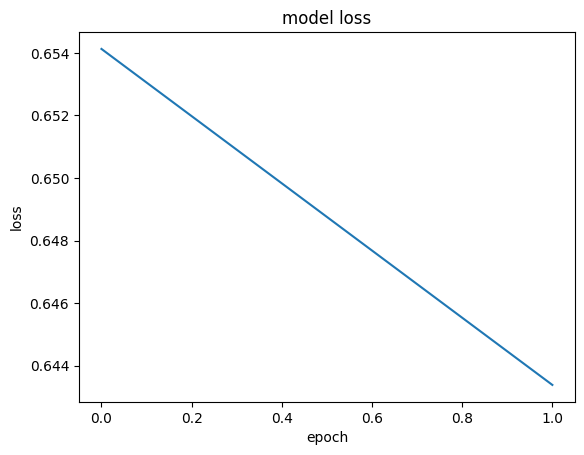

In [20]:
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Predict/Detect Anomalies
Calculate the reconstruction error on new data.

In [21]:
reconstructed = model.predict(windows)

89439/89439 [==============================] - 206s 2ms/step


In [22]:
print("Reconstructed Shape:", reconstructed.shape)
print("Windows Shape:", windows.shape)

[[0.25910482]
 [0.25914663]
 [0.25918463]
 ...
 [0.25901157]
 [0.2590108 ]
 [0.25900993]]
(2862047, 1)
(2862047,)
0.9889641
0.24874395
(2862047, 16, 1)


# Calculate Mean Squared Error (MSE)

In [23]:
mse = np.mean(np.power(windows[:, :, 0] - reconstructed, 2), axis=1)
print("MSE Shape:", mse.shape)

[0.06594677 0.06596011 0.06596987 ... 0.06589437 0.06589393 0.0658935 ]
191.31693
0.0017533622
487623
2863


# Set a Threshold for Anomaly Detection Based on the MSE Quantile Values

In [ ]:
high1 = np.quantile(np.abs(mse), 0.999)
# high2 = np.quantile(np.abs(mse), 0.9951)
anomalies_label = [1 if i > high1 else 0 for i in mse]
print("Predicted Anomaly Position:", np.argmax(anomalies_label))
print(
    "Predicted Number of Anomalies:",
    np.count_nonzero(anomalies_label),
    "(depends directly on the quantile range)",
)

# Plot the Seismic Data and Scatterplot of the Predicted Data of Every Event Input

572415


TypeError: 'numpy.int64' object is not iterable

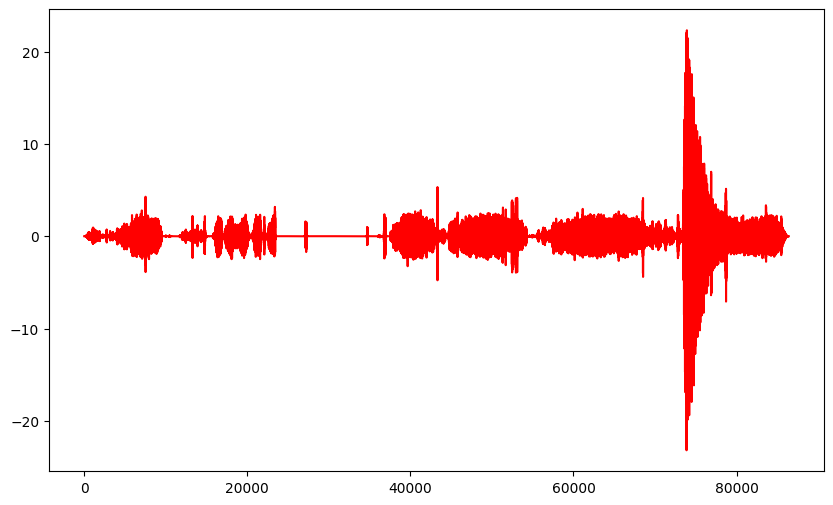

In [35]:
for i in event:
    length = lens_array[i]
    print(length)
    tiempo = time_array[i]
    X = data_arrays[i]
    colors = [
        "red",
        "green",
        "blue",
        "orange",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ][i]

    plt.figure(figsize=(10, 6))

    plt.plot(
        tiempo,
        X,
        label="Seismic Activity",
        color=colors,
    )

    anomaly_indices = np.where(anomalies_label)[i][0]
    indices = np.array([])
    for j in anomaly_indices:
        if j <= length:
            indices = np.append(indices, j)

    indices = indices.astype(int)  # Ensure indices are integers
    print(indices)

    arrival_line = plt.axvline(
        x=true_anomaly_time[i], c="green", label="True Arrival Time"
    )
    arrival_line = plt.axvline(
        x=indices[0] / 6.625,
        c="blue",
        label="Predicted Arrival Time",
    )

    plt.scatter(
        time[indices + windows_size],
        X_standard[indices + windows_size],
        color="k",
        label="Anomalies",
        marker="o",
        s=1,
        zorder=2,
    )
    plt.title(f"Seismic Activity for Event {i}")
    plt.xlabel("Time (Relative Seconds)")
    plt.ylabel("Normalized Velocity (m/s)")
    plt.legend()
    plt.show()  # Show the plot for the current event

# EXTRA: Confusion Matrix
Not really valid...

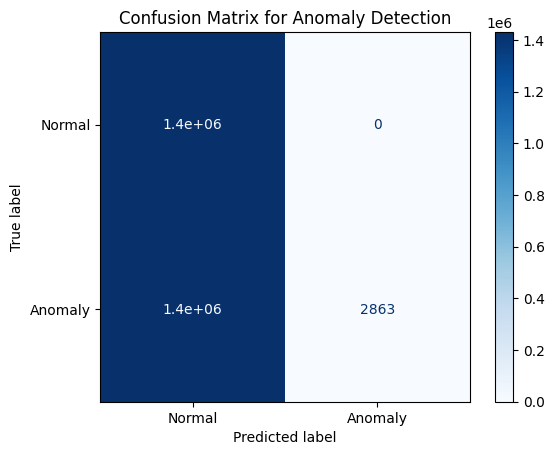

In [28]:
conf_matrix = confusion_matrix(y, anomalies_label)

display = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=["Normal", "Anomaly"]
)

display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Anomaly Detection")
plt.show()

# Extract Model

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 16)            64        
                                                                 
 batch_normalization (BatchN  (None, 14, 16)           64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 14, 16)            0         
                                                                 
 dropout (Dropout)           (None, 14, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            1568      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 32)           128       
 hNormalization)                                        

In [31]:
model.save("cnn_triangular.keras")
model.save("cnn_triangular.h5")

# Extract Data

In [32]:
results_df = pd.DataFrame(
    {
        "true_labels": y,
        "predictions": reconstructed.flatten(),
        "mse": mse,
        "anomalies": anomalies_label,
    }
)

results_df.to_csv("./extract/cnn_triangular_seismic_results.csv", index=False)

anomalies_df = pd.DataFrame(
    {"time_rel(sec)": time_array[windows_size:], "anomalies": anomalies_label}
)

anomalies_df.to_csv("./extract/cnn_triangular_seismic_anomalies.csv", index=False)